In [37]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [38]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [39]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [40]:
batch_size= 64

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
#     A.Resize(64,64),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
#     A.Resize(64,64),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
len(train_set) + len(val_set) + len(test_set)

35887

In [70]:
counter = 0
subs = os.listdir('/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/Training/')

for sub in subs:
    counter += len(os.listdir('/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/Training/' + sub))

for sub in subs:
    counter += len(os.listdir('/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PublicTest/' + sub))
    
for sub in subs:
    counter += len(os.listdir('/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PrivateTest/' + sub))

counter

35772

In [43]:
class SamplingDepth(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(SamplingDepth, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_channels, out_channels)
        self.dropout = nn.Dropout(dropout, inplace=False)
        
        # options
#         self.activation = nn.ReLU(inplace=True)
        self.activation = nn.Sigmoid()
#         self.activation = nn.Softmax()
        
    def forward(self, x):
        x = self.global_pool(x)
        x = nn.Flatten()(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.activation(x)
        
        return x

In [44]:
class SamplingSize(nn.Module):
    def __init__(self, size, depth):
        super(SamplingSize, self).__init__()
        
        self.size = size
        self.conv1x1 = nn.Conv2d(depth, 1, kernel_size=1, padding=0, stride=1)
        self.fc = nn.Linear(size[0]*size[1], size[0]*size[1])
        
         # options
        # self.activation = nn.ReLU(inplace=True)
        self.activation = nn.Sigmoid()
#         self.activation = nn.Softmax()

    def forward(self, x):
        x = self.conv1x1(x)
        x = nn.Flatten()(x)
        x = self.fc(x)
        x = self.activation(x)
        
        x = x.reshape(-1, 1, self.size[0], self.size[1])
        
        return x
        

In [45]:
class SamplingInstance(nn.Module):
    def __init__(self, in_size, out_size):
        super(SamplingInstance, self).__init__()
        
        self.out_size = out_size
        self.fc = nn.Linear(in_size[1]*in_size[2], out_size[1]*out_size[2])
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = x.reshape(-1, x.size(1), x.size(2)*x.size(3))
        x = self.fc(x)
        x = self.activation(x)
        
        x = x.reshape(-1, x.size(1), self.out_size[1], self.out_size[2])
        
        return x

In [7]:
MAX_LOGSTD = 10
class SamplingLatentSpace(nn.Module):
    def __init__(self, in_size, out_size):
        super(SamplingLatentSpace, self).__init__()
        
        
        self.in_size = in_size
        self.out_size = out_size

        self.relu = nn.ReLU()
        
        self.encode_conv = nn.Conv2d(in_size[0], out_size[0], kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.dim = out_size[0] * out_size[1] * out_size[2]
        self.fc_mu = nn.Linear(self.dim, self.dim)
        self.fc_logvar = nn.Linear(self.dim, self.dim)
        
        # self.decode_fc = nn.Linear(dim, fdim)
        # self.decode_conv = nn.ConvTranspose2d(mid_dim, in_size[0], kernel_size=3, padding=1)
        
    # def reparameterize(self, mu, logvar):
    #     std = torch.exp(logvar / 2)
    #     eps = torch.randn_like(std)
        
    #     return mu + std*eps

    def reparameterize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def kl_loss(self, mu, logstd):
        logstd = logstd.clamp(max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))
        
    def forward(self, x):
        
        # encode
        _x = self.encode_conv(x)
        _x = self.relu(_x)

        # _x = self.avgpool(x)
        _x = self.flatten(_x)
        
        x_mu = self.fc_mu(_x)
        x_logvar = self.fc_logvar(_x)
        
        # sampling
        z = self.reparameterize(x_mu, x_logvar)

        # reshape
        z = z.reshape(-1, self.out_size[0], self.out_size[1], self.out_size[2])
        
        return z, self.kl_loss(x_mu, x_logvar)
        

In [9]:
class SamplingAtt(nn.Module):
    def __init__(self, in_size, out_size):
        super(SamplingAtt, self).__init__()

        self.f_depth = SamplingDepth(in_size[0], out_size[0])
        self.f_spatial = SamplingSize((in_size[1], out_size[1]), out_size[0])
#         self.f_sampling = SamplingLatentSpace(in_size, out_size)

        self.lambd = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        x_depth = self.f_depth(x)
        x_spatial = self.f_spatial(x)

#         z, kl_loss = self.f_sampling(x)
        z = x
        out = (self.lambd*(z*x_depth[:,:,None,None])) + ((1 - self.lambd)*(z*x_spatial))

#         return out, kl_loss
        return out, 0.0

In [50]:
class pretrainedVGG_MultiAtt(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        
        super(pretrainedVGG_MultiAtt, self).__init__()
        pretrained = models.vgg16_bn(pretrained=False)
        
        self.pre_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1)
        self.block1 = pretrained.features[1:7]
        self.block2 = pretrained.features[7:14]
        self.block3 = pretrained.features[14:24]
#         self.block4 = pretrained.features[24:34]
#         self.block5 = pretrained.features[34:]
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Sequential(nn.Linear(in_features=256, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=7, bias=True))
        
        
        self.att2 = SamplingAtt((128, 12, 12), (128, 12, 12))
        self.att3 = SamplingAtt((256, 6, 6), (256, 6, 6))
#         self.att4 = SamplingAtt((512, 4, 4), (512, 4, 4))
        
        
    def forward(self, x):
        x = self.pre_conv(x)
        x = self.block1(x)
        
        x = self.block2(x)
        x, kl2 = self.att2(x)
        
        x = self.block3(x)
        x, kl3 = self.att3(x)
        
#         x = self.block4(x)
#         x, kl4 = self.att4(x)
        
#         x = self.block5(x)
#         x, kl5 = self.att5(x)
        
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.classifier(x)
        
        return x, torch.tensor([kl2, kl3]).sum()
        

In [51]:
device = torch.device('cuda')
model = pretrainedVGG_MultiAtt().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [16]:
MAX_LOGSTD=10
model_path = 'squeeze_excit_model/sqeeuze_excit_3blocks_model.pt'

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs)) * kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss = model(inputs)
        
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs))*kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.5807950496673584 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:18<00:00, 24.24it/s]

- Avg.loss: 1.6812 | Avg.acc: 0.3080



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4472 | Avg. val_acc: 0.4168
* Update optimal model
Epoch:  2


Loss=1.1672338247299194 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 24.20it/s]

- Avg.loss: 1.4531 | Avg.acc: 0.4304



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7161 | Avg. val_acc: 0.3647
Epoch:  3


Loss=1.223245620727539 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 24.05it/s]

- Avg.loss: 1.3201 | Avg.acc: 0.4937



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2273 | Avg. val_acc: 0.5222
* Update optimal model
Epoch:  4


Loss=1.360426664352417 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 23.98it/s]

- Avg.loss: 1.2414 | Avg.acc: 0.5258



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1895 | Avg. val_acc: 0.5422
* Update optimal model
Epoch:  5


Loss=1.2280100584030151 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 24.33it/s]

- Avg.loss: 1.1892 | Avg.acc: 0.5497



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1904 | Avg. val_acc: 0.5425
* Update optimal model
Epoch:  6


Loss=1.2588590383529663 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:18<00:00, 24.36it/s]

- Avg.loss: 1.1473 | Avg.acc: 0.5694



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1727 | Avg. val_acc: 0.5525
* Update optimal model
Epoch:  7


Loss=1.235944151878357 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 24.02it/s]

- Avg.loss: 1.1102 | Avg.acc: 0.5821



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0851 | Avg. val_acc: 0.5879
* Update optimal model
Epoch:  8


Loss=1.3330386877059937 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:18<00:00, 24.08it/s]

- Avg.loss: 1.0701 | Avg.acc: 0.6002



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0908 | Avg. val_acc: 0.5862
Epoch:  9


Loss=0.9549452066421509 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 24.17it/s]

- Avg.loss: 1.0445 | Avg.acc: 0.6116



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1096 | Avg. val_acc: 0.5832
Epoch:  10


Loss=1.2577532529830933 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:18<00:00, 24.45it/s]

- Avg.loss: 1.0072 | Avg.acc: 0.6255



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0404 | Avg. val_acc: 0.6060
* Update optimal model
Epoch:  11


Loss=0.8029928207397461 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 24.13it/s]

- Avg.loss: 0.9855 | Avg.acc: 0.6321



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0733 | Avg. val_acc: 0.6013
Epoch:  12


Loss=0.7589288949966431 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 23.83it/s]

- Avg.loss: 0.9670 | Avg.acc: 0.6448



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1039 | Avg. val_acc: 0.5993
Epoch:  13


Loss=0.8803459405899048 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:18<00:00, 24.34it/s]

- Avg.loss: 0.9378 | Avg.acc: 0.6569



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0578 | Avg. val_acc: 0.6077
* Update optimal model
Epoch:  14


Loss=1.130103588104248 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:18<00:00, 24.16it/s]

- Avg.loss: 0.9101 | Avg.acc: 0.6661



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0216 | Avg. val_acc: 0.6236
* Update optimal model
Epoch:  15


Loss=1.075650930404663 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:18<00:00, 24.01it/s]

- Avg.loss: 0.8915 | Avg.acc: 0.6708



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.9989 | Avg. val_acc: 0.6342
* Update optimal model
Epoch:  16


Loss=0.7323378324508667 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:18<00:00, 24.04it/s]

- Avg.loss: 0.8646 | Avg.acc: 0.6857



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0515 | Avg. val_acc: 0.6166
Epoch:  17


Loss=0.9637969732284546 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:18<00:00, 24.12it/s]

- Avg.loss: 0.8433 | Avg.acc: 0.6953



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0194 | Avg. val_acc: 0.6361
* Update optimal model
Epoch:  18


Loss=0.7248056530952454 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 23.84it/s]

- Avg.loss: 0.8209 | Avg.acc: 0.7032



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0168 | Avg. val_acc: 0.6408
* Update optimal model
Epoch:  19


Loss=0.9543427228927612 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:18<00:00, 23.99it/s]

- Avg.loss: 0.7995 | Avg.acc: 0.7102



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.9949 | Avg. val_acc: 0.6442
* Update optimal model
Epoch:  20


Loss=1.0142539739608765 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 24.10it/s]

- Avg.loss: 0.7697 | Avg.acc: 0.7220



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0784 | Avg. val_acc: 0.6266
Epoch:  21


Loss=0.8976228833198547 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 24.23it/s]

- Avg.loss: 0.7584 | Avg.acc: 0.7285



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0518 | Avg. val_acc: 0.6364
Epoch:  22


Loss=0.7573308944702148 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:18<00:00, 24.18it/s]

- Avg.loss: 0.7269 | Avg.acc: 0.7415



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0408 | Avg. val_acc: 0.6389
Epoch:  23


Loss=0.7342675924301147 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:18<00:00, 23.93it/s]

- Avg.loss: 0.7119 | Avg.acc: 0.7470



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0688 | Avg. val_acc: 0.6330
Epoch:  24


Loss=0.818073034286499 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:18<00:00, 24.25it/s]

- Avg.loss: 0.6898 | Avg.acc: 0.7552



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0678 | Avg. val_acc: 0.6439
Epoch:  25


Loss=0.8990858197212219 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:18<00:00, 23.94it/s]

- Avg.loss: 0.6710 | Avg.acc: 0.7621



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0519 | Avg. val_acc: 0.6539
* Update optimal model
Epoch:  26


Loss=0.7676265239715576 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:18<00:00, 24.18it/s]

- Avg.loss: 0.6481 | Avg.acc: 0.7732



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0641 | Avg. val_acc: 0.6503
Epoch:  27


Loss=0.7023314237594604 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 24.34it/s]

- Avg.loss: 0.6273 | Avg.acc: 0.7772



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1415 | Avg. val_acc: 0.6436
Epoch:  28


Loss=0.3453218340873718 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:18<00:00, 23.95it/s]

- Avg.loss: 0.6132 | Avg.acc: 0.7827



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1440 | Avg. val_acc: 0.6425
Epoch:  29


Loss=0.5127198696136475 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:18<00:00, 24.16it/s]

- Avg.loss: 0.5876 | Avg.acc: 0.7932



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1229 | Avg. val_acc: 0.6422
Epoch:  30


Loss=0.6676416397094727 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 24.14it/s]

- Avg.loss: 0.5777 | Avg.acc: 0.7956



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1574 | Avg. val_acc: 0.6542
* Update optimal model
Epoch:  31


Loss=0.5958837270736694 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:18<00:00, 24.16it/s]

- Avg.loss: 0.5665 | Avg.acc: 0.8019



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1858 | Avg. val_acc: 0.6439
Epoch:  32


Loss=1.0216740369796753 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 24.10it/s]

- Avg.loss: 0.5436 | Avg.acc: 0.8071



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2184 | Avg. val_acc: 0.6434
Epoch:  33


Loss=0.7041361331939697 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 23.88it/s]

- Avg.loss: 0.4283 | Avg.acc: 0.8547



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3410 | Avg. val_acc: 0.6567
Epoch:  39


Loss=0.26353561878204346 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.30it/s]

- Avg.loss: 0.4221 | Avg.acc: 0.8567



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3161 | Avg. val_acc: 0.6565
Epoch:  40


Loss=0.380174845457077 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.41it/s]

- Avg.loss: 0.4112 | Avg.acc: 0.8600



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4051 | Avg. val_acc: 0.6553
Epoch:  41


Loss=0.294068306684494 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 23.79it/s]

- Avg.loss: 0.4001 | Avg.acc: 0.8620



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3340 | Avg. val_acc: 0.6537
Epoch:  42


Loss=0.323068767786026 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.16it/s]

- Avg.loss: 0.3875 | Avg.acc: 0.8646



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4633 | Avg. val_acc: 0.6506
Epoch:  43


Loss=0.37203311920166016 Batch_id=6 Accuracy=0.859375:   2%|▏         | 7/449 [00:00<01:45,  4.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.12392999976873398 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:18<00:00, 24.40it/s]     

- Avg.loss: 0.2981 | Avg.acc: 0.8976



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5845 | Avg. val_acc: 0.6573
Epoch:  55


Loss=0.3822750449180603 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:18<00:00, 24.05it/s]

- Avg.loss: 0.2959 | Avg.acc: 0.8996



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5282 | Avg. val_acc: 0.6517
Epoch    55: reducing learning rate of group 0 to 4.2188e-04.
Epoch:  56


Loss=0.3941275477409363 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:18<00:00, 24.01it/s]

- Avg.loss: 0.2612 | Avg.acc: 0.9127



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6366 | Avg. val_acc: 0.6570
Epoch:  57


Loss=0.047079671174287796 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:18<00:00, 24.08it/s]    

- Avg.loss: 0.2551 | Avg.acc: 0.9121



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6761 | Avg. val_acc: 0.6626
Epoch:  58


Loss=0.1782824993133545 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:18<00:00, 23.94it/s]

- Avg.loss: 0.2524 | Avg.acc: 0.9152



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7416 | Avg. val_acc: 0.6556
Epoch:  59


Loss=0.17127300798892975 Batch_id=408 Accuracy=0.96875:  90%|█████████ | 406/449 [00:17<00:01, 23.99it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.4034154713153839 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.40it/s]

- Avg.loss: 0.2456 | Avg.acc: 0.9160



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7783 | Avg. val_acc: 0.6645
Epoch:  61


Loss=0.4285125732421875 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:18<00:00, 24.20it/s]

- Avg.loss: 0.2473 | Avg.acc: 0.9146



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7573 | Avg. val_acc: 0.6587
Epoch    61: reducing learning rate of group 0 to 3.1641e-04.
Epoch:  62


Loss=0.2462478131055832 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:18<00:00, 23.89it/s]

- Avg.loss: 0.2302 | Avg.acc: 0.9220



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7227 | Avg. val_acc: 0.6670
* Update optimal model
Epoch:  63


Loss=0.205800861120224 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 23.74it/s]

- Avg.loss: 0.2083 | Avg.acc: 0.9290



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8305 | Avg. val_acc: 0.6656
Epoch:  68


Loss=0.24754072725772858 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 23.95it/s]

- Avg.loss: 0.2116 | Avg.acc: 0.9287



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8328 | Avg. val_acc: 0.6668
Epoch:  69


Loss=0.3054593503475189 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.09it/s]

- Avg.loss: 0.2061 | Avg.acc: 0.9295



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7770 | Avg. val_acc: 0.6676
Epoch    69: reducing learning rate of group 0 to 2.3730e-04.
Epoch:  70


Loss=0.23925791680812836 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 23.93it/s]

- Avg.loss: 0.1963 | Avg.acc: 0.9339



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7572 | Avg. val_acc: 0.6684
Epoch:  71


Loss=0.44208401441574097 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 24.20it/s]

- Avg.loss: 0.1885 | Avg.acc: 0.9354



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8284 | Avg. val_acc: 0.6654
Epoch:  72


Loss=0.18924827873706818 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.33it/s]

- Avg.loss: 0.1850 | Avg.acc: 0.9357



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8654 | Avg. val_acc: 0.6690
Epoch:  73


Loss=0.06186779588460922 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.01it/s]

- Avg.loss: 0.1767 | Avg.acc: 0.9402



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8950 | Avg. val_acc: 0.6673
Epoch:  74


Loss=0.3204614222049713 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.40it/s]

- Avg.loss: 0.1823 | Avg.acc: 0.9390



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8741 | Avg. val_acc: 0.6693
Epoch:  75


Loss=0.073865607380867 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.18it/s]

- Avg.loss: 0.1822 | Avg.acc: 0.9383



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8559 | Avg. val_acc: 0.6723
Epoch    75: reducing learning rate of group 0 to 1.7798e-04.
Epoch:  76


Loss=0.15764650702476501 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 24.08it/s]

- Avg.loss: 0.1716 | Avg.acc: 0.9412



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8853 | Avg. val_acc: 0.6732
Epoch:  77


Loss=0.40378129482269287 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 23.93it/s]

- Avg.loss: 0.1628 | Avg.acc: 0.9447



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9425 | Avg. val_acc: 0.6676
Epoch:  78


Loss=0.09399513900279999 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 23.72it/s]

- Avg.loss: 0.1577 | Avg.acc: 0.9455



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8556 | Avg. val_acc: 0.6662
Epoch:  79


Loss=0.07263307273387909 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 23.94it/s]

- Avg.loss: 0.1627 | Avg.acc: 0.9453



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8439 | Avg. val_acc: 0.6709
Epoch:  80


Loss=0.12144261598587036 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 23.72it/s]

- Avg.loss: 0.1585 | Avg.acc: 0.9472



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8981 | Avg. val_acc: 0.6754
Epoch:  81


Loss=0.2600880563259125 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.17it/s]

- Avg.loss: 0.1587 | Avg.acc: 0.9454



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8860 | Avg. val_acc: 0.6765
Epoch    81: reducing learning rate of group 0 to 1.3348e-04.
Epoch:  82


Loss=0.13848845660686493 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 23.76it/s]

- Avg.loss: 0.1502 | Avg.acc: 0.9494



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9331 | Avg. val_acc: 0.6695
Epoch:  83


Loss=0.08828649669885635 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.88it/s]

- Avg.loss: 0.1449 | Avg.acc: 0.9512



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9133 | Avg. val_acc: 0.6760
Epoch:  84


Loss=0.12173322588205338 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.06it/s]

- Avg.loss: 0.1458 | Avg.acc: 0.9509



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9686 | Avg. val_acc: 0.6701
Epoch:  85


Loss=0.10472030937671661 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 23.89it/s]

- Avg.loss: 0.1505 | Avg.acc: 0.9494



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9584 | Avg. val_acc: 0.6729
Epoch:  86


Loss=0.05398465320467949 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:18<00:00, 24.15it/s]      

- Avg.loss: 0.1405 | Avg.acc: 0.9524



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9109 | Avg. val_acc: 0.6718
Epoch:  87


Loss=0.07790233939886093 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.21it/s]

- Avg.loss: 0.1428 | Avg.acc: 0.9503



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9258 | Avg. val_acc: 0.6729
Epoch    87: reducing learning rate of group 0 to 1.0011e-04.
Epoch:  88


Loss=0.18885545432567596 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.28it/s]

- Avg.loss: 0.1303 | Avg.acc: 0.9545



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9763 | Avg. val_acc: 0.6751
Epoch:  89


Loss=0.201009601354599 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.15it/s]

- Avg.loss: 0.1297 | Avg.acc: 0.9551



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9705 | Avg. val_acc: 0.6732
Epoch:  90


Loss=0.228921040892601 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 23.86it/s]

- Avg.loss: 0.1303 | Avg.acc: 0.9556



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9197 | Avg. val_acc: 0.6726
Epoch:  91


Loss=0.05217078700661659 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.72it/s]

- Avg.loss: 0.1259 | Avg.acc: 0.9568



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9690 | Avg. val_acc: 0.6796
Epoch:  92


Loss=0.09269191324710846 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.61it/s]

- Avg.loss: 0.1298 | Avg.acc: 0.9545



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9573 | Avg. val_acc: 0.6698
Epoch:  93


Loss=0.1365111619234085 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.27it/s]

- Avg.loss: 0.1279 | Avg.acc: 0.9572



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9348 | Avg. val_acc: 0.6801
Epoch    93: reducing learning rate of group 0 to 7.5085e-05.
Epoch:  94


Loss=0.09513857215642929 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.14it/s]

- Avg.loss: 0.1220 | Avg.acc: 0.9574



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9610 | Avg. val_acc: 0.6723
Epoch:  95


Loss=0.2438884973526001 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.28it/s]

- Avg.loss: 0.1192 | Avg.acc: 0.9586



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0290 | Avg. val_acc: 0.6793
Epoch:  96


Loss=0.10589592903852463 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 24.05it/s]

- Avg.loss: 0.1260 | Avg.acc: 0.9555



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9879 | Avg. val_acc: 0.6790
Epoch:  97


Loss=0.06458287686109543 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.21it/s]

- Avg.loss: 0.1206 | Avg.acc: 0.9581



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0145 | Avg. val_acc: 0.6734
Epoch:  98


Loss=0.10325245559215546 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 23.98it/s]

- Avg.loss: 0.1191 | Avg.acc: 0.9587



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9665 | Avg. val_acc: 0.6729
Epoch:  99


Loss=0.033409927040338516 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:18<00:00, 24.28it/s]     

- Avg.loss: 0.1170 | Avg.acc: 0.9592



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9889 | Avg. val_acc: 0.6734
Epoch    99: reducing learning rate of group 0 to 5.6314e-05.
Epoch:  100


Loss=0.04669753462076187 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.56it/s]      

- Avg.loss: 0.1105 | Avg.acc: 0.9603


- Avg. val_loss: 2.0373 | Avg. val_acc: 0.6826
* Update optimal model
Finished Training


In [19]:
MAX_LOGSTD=10
model_path = 'squeeze_excit_model/sqeeuze_excit_3blocks_model.pt'

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(100, 110):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs)) * kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss = model(inputs)
        
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs))*kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  101


Loss=0.06746342033147812 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.90it/s]

- Avg.loss: 0.1104 | Avg.acc: 0.9629



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0486 | Avg. val_acc: 0.6824
Epoch:  102


Loss=0.1636260598897934 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 24.00it/s]

- Avg.loss: 0.1127 | Avg.acc: 0.9615



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0461 | Avg. val_acc: 0.6765
Epoch:  103


Loss=0.21794499456882477 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:18<00:00, 23.85it/s]

- Avg.loss: 0.1084 | Avg.acc: 0.9625



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0222 | Avg. val_acc: 0.6796
Epoch:  104


Loss=0.12339136749505997 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 24.23it/s]

- Avg.loss: 0.1123 | Avg.acc: 0.9616



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0005 | Avg. val_acc: 0.6729
Epoch:  105


Loss=0.23570466041564941 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.46it/s]

- Avg.loss: 0.1090 | Avg.acc: 0.9625



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0104 | Avg. val_acc: 0.6765
Epoch:  106


Loss=0.049922097474336624 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.90it/s]

- Avg.loss: 0.1110 | Avg.acc: 0.9625



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0158 | Avg. val_acc: 0.6718
Epoch   106: reducing learning rate of group 0 to 4.2235e-05.
Epoch:  107


Loss=0.14531052112579346 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 23.66it/s]

- Avg.loss: 0.1083 | Avg.acc: 0.9627



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9991 | Avg. val_acc: 0.6773
Epoch:  108


Loss=0.12203007936477661 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.05it/s]

- Avg.loss: 0.1041 | Avg.acc: 0.9636



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0600 | Avg. val_acc: 0.6743
Epoch:  109


Loss=0.3160066604614258 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:18<00:00, 24.09it/s]

- Avg.loss: 0.1060 | Avg.acc: 0.9639



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0044 | Avg. val_acc: 0.6737
Epoch:  110


Loss=0.0753098875284195 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.02it/s]

- Avg.loss: 0.1026 | Avg.acc: 0.9650


- Avg. val_loss: 2.0523 | Avg. val_acc: 0.6748
Finished Training


([<matplotlib.lines.Line2D at 0x7fb9543e0860>,
 0.6826414042908888)

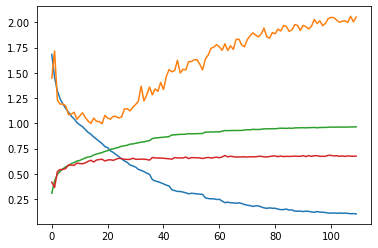

In [21]:
import pickle
pickle.dump(hist, open('squeeze_excit_model/sqeeuze_excit_3blocks_hist.hdf5', 'wb'))
plt.plot(hist), best_acc

In [42]:
# EVALUATE
def test(model, test_loader,device):
    model = model.to(device)
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss = model(inputs)

        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs))*kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))
    
    return running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)

In [23]:
## Test
MAX_LOGSTD=10
device = torch.device('cuda')
model = torch.load('squeeze_excit_model/sqeeuze_excit_3blocks_model.pt')

test(model, test_loader, device)

- Avg. val_loss: 1.8817 | Avg. val_acc: 0.6916


(1.881658147523316, 0.6915575369183616)

### Add sampling instance

In [49]:
class SamplingAtt(nn.Module):
    def __init__(self, in_size, out_size):
        super(SamplingAtt, self).__init__()

        self.f_depth = SamplingDepth(in_size[0], out_size[0])
#         self.f_spatial = SamplingSize((in_size[1], out_size[1]), out_size[0])
        self.f_instance = SamplingInstance(in_size, out_size)
#         self.f_sampling = SamplingLatentSpace(in_size, out_size)

#         self.lambd = nn.Parameter(torch.tensor(0.), requires_grad=True)
#         self.lambd_spatial = nn.Parameter(torch.tensor(0.), requires_grad=True)
#         self.lambd_instance = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        x_depth = self.f_depth(x)
#         x_spatial = self.f_spatial(x)
        x_instance = self.f_instance(x)

#         z, kl_loss = self.f_sampling(x)
        z = x
#         out = (self.lambd.sigmoid()*(z*x_depth[:,:,None,None])) + ((1-self.lambd.sigmoid())*(z*x_instance))
        out = (z*x_depth[:,:,None,None]) + (z*x_instance)

#         return out, kl_loss
        return out, 0.0

In [ ]:
MAX_LOGSTD=10
model_path = 'squeeze_excit_model/sqeeuze_excit_3blocks_sinstance_model.pt'

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs)) * kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss = model(inputs)
        
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs))*kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.3968058824539185 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:17<00:00, 25.56it/s]

- Avg.loss: 1.6727 | Avg.acc: 0.3260



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4827 | Avg. val_acc: 0.4193
* Update optimal model
Epoch:  2


Loss=1.2223745584487915 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:17<00:00, 25.28it/s]

- Avg.loss: 1.4270 | Avg.acc: 0.4509



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3650 | Avg. val_acc: 0.4742
* Update optimal model
Epoch:  3


Loss=1.2793091535568237 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:17<00:00, 25.42it/s]

- Avg.loss: 1.3118 | Avg.acc: 0.4967



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2401 | Avg. val_acc: 0.5174
* Update optimal model
Epoch:  4


Loss=1.289341926574707 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 24.92it/s]

- Avg.loss: 1.2389 | Avg.acc: 0.5300



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3982 | Avg. val_acc: 0.4770
Epoch:  5


Loss=1.3301235437393188 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:17<00:00, 25.07it/s]

- Avg.loss: 1.1901 | Avg.acc: 0.5521



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1462 | Avg. val_acc: 0.5595
* Update optimal model
Epoch:  6


Loss=1.2536309957504272 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:18<00:00, 24.87it/s]

- Avg.loss: 1.1469 | Avg.acc: 0.5676



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1414 | Avg. val_acc: 0.5506
Epoch:  7


Loss=1.3291376829147339 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 24.89it/s]

- Avg.loss: 1.1138 | Avg.acc: 0.5858



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1291 | Avg. val_acc: 0.5717
* Update optimal model
Epoch:  8


Loss=1.1159656047821045 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:18<00:00, 24.89it/s]

- Avg.loss: 1.0802 | Avg.acc: 0.6013



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1620 | Avg. val_acc: 0.5578
Epoch:  9


Loss=1.192682147026062 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:17<00:00, 25.01it/s]

- Avg.loss: 1.0530 | Avg.acc: 0.6099



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0674 | Avg. val_acc: 0.6035
* Update optimal model
Epoch:  10


Loss=1.259385108947754 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:17<00:00, 25.23it/s]

- Avg.loss: 1.0276 | Avg.acc: 0.6219



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0443 | Avg. val_acc: 0.6074
* Update optimal model
Epoch:  11


Loss=0.8519909381866455 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:18<00:00, 24.65it/s]

- Avg.loss: 1.0003 | Avg.acc: 0.6323



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0399 | Avg. val_acc: 0.6160
* Update optimal model
Epoch:  12


Loss=0.8369278907775879 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:18<00:00, 24.57it/s]

- Avg.loss: 0.9771 | Avg.acc: 0.6426



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0119 | Avg. val_acc: 0.6205
* Update optimal model
Epoch:  13


Loss=1.3638217449188232 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:17<00:00, 25.01it/s]

- Avg.loss: 0.9562 | Avg.acc: 0.6517



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0268 | Avg. val_acc: 0.6236
* Update optimal model
Epoch:  14


Loss=0.8754573464393616 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:17<00:00, 25.24it/s]

- Avg.loss: 0.9393 | Avg.acc: 0.6598



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0298 | Avg. val_acc: 0.6216
Epoch:  15


Loss=0.958383321762085 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:17<00:00, 25.29it/s]

- Avg.loss: 0.9156 | Avg.acc: 0.6666



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0206 | Avg. val_acc: 0.6250
* Update optimal model
Epoch:  16


Loss=0.7140704393386841 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:17<00:00, 25.30it/s]

- Avg.loss: 0.8991 | Avg.acc: 0.6725



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0014 | Avg. val_acc: 0.6339
* Update optimal model
Epoch:  17


Loss=0.7291280627250671 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:18<00:00, 24.79it/s]

- Avg.loss: 0.8835 | Avg.acc: 0.6812



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0054 | Avg. val_acc: 0.6266
Epoch:  18


Loss=0.8446237444877625 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:17<00:00, 25.18it/s]

- Avg.loss: 0.8583 | Avg.acc: 0.6895



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.9817 | Avg. val_acc: 0.6408
* Update optimal model
Epoch:  19


Loss=0.8306087851524353 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:18<00:00, 24.92it/s]

- Avg.loss: 0.8437 | Avg.acc: 0.6956



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0050 | Avg. val_acc: 0.6336
Epoch:  20


Loss=0.9030305743217468 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:17<00:00, 25.31it/s]

- Avg.loss: 0.8169 | Avg.acc: 0.7081



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0061 | Avg. val_acc: 0.6414
* Update optimal model
Epoch:  21


Loss=0.9472714066505432 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:18<00:00, 24.86it/s]

- Avg.loss: 0.7964 | Avg.acc: 0.7150



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0209 | Avg. val_acc: 0.6358
Epoch:  22


Loss=0.6069049835205078 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:18<00:00, 24.82it/s]

- Avg.loss: 0.7758 | Avg.acc: 0.7260



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0181 | Avg. val_acc: 0.6383
Epoch:  23


Loss=0.5929403901100159 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:17<00:00, 25.11it/s]

- Avg.loss: 0.7574 | Avg.acc: 0.7331



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0390 | Avg. val_acc: 0.6369
Epoch:  24


Loss=0.6331678032875061 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:17<00:00, 25.14it/s]

- Avg.loss: 0.7402 | Avg.acc: 0.7389



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0353 | Avg. val_acc: 0.6489
* Update optimal model
Epoch:  25


Loss=0.7763287425041199 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:17<00:00, 25.07it/s]

- Avg.loss: 0.7211 | Avg.acc: 0.7478



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0610 | Avg. val_acc: 0.6442
Epoch:  26


Loss=0.789008617401123 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:17<00:00, 25.15it/s]

- Avg.loss: 0.7062 | Avg.acc: 0.7497



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1983 | Avg. val_acc: 0.6004
Epoch:  27


Loss=0.5517776608467102 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:18<00:00, 24.89it/s]

- Avg.loss: 0.6868 | Avg.acc: 0.7591



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0098 | Avg. val_acc: 0.6598
* Update optimal model
Epoch:  28


Loss=0.34859150648117065 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.76it/s]

- Avg.loss: 0.6779 | Avg.acc: 0.7619



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0519 | Avg. val_acc: 0.6456
Epoch:  29


Loss=0.9331653714179993 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:17<00:00, 25.14it/s]

- Avg.loss: 0.6574 | Avg.acc: 0.7694



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1796 | Avg. val_acc: 0.6186
Epoch:  30


Loss=0.6742237210273743 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:18<00:00, 24.72it/s]

- Avg.loss: 0.6341 | Avg.acc: 0.7773



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0978 | Avg. val_acc: 0.6537
Epoch:  31


Loss=0.7213538885116577 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 24.86it/s]

- Avg.loss: 0.6209 | Avg.acc: 0.7840



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0508 | Avg. val_acc: 0.6439
Epoch:  32


Loss=0.5304309129714966 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:17<00:00, 25.10it/s]

- Avg.loss: 0.6123 | Avg.acc: 0.7878



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0983 | Avg. val_acc: 0.6408
Epoch:  33


Loss=0.6513909101486206 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:17<00:00, 24.97it/s]

- Avg.loss: 0.5971 | Avg.acc: 0.7937



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1115 | Avg. val_acc: 0.6486
Epoch    33: reducing learning rate of group 0 to 7.5000e-04.
Epoch:  34


Loss=0.5339080095291138 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:17<00:00, 25.39it/s]

- Avg.loss: 0.5347 | Avg.acc: 0.8147



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2202 | Avg. val_acc: 0.6381
Epoch:  35


Loss=0.88739413022995 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 24.82it/s]

- Avg.loss: 0.5084 | Avg.acc: 0.8240



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2375 | Avg. val_acc: 0.6470
Epoch:  36


Loss=0.625271737575531 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:17<00:00, 25.08it/s]

- Avg.loss: 0.4903 | Avg.acc: 0.8335



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2342 | Avg. val_acc: 0.6620
* Update optimal model
Epoch:  37


Loss=0.4608924388885498 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:17<00:00, 25.00it/s]

- Avg.loss: 0.4864 | Avg.acc: 0.8302



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2299 | Avg. val_acc: 0.6665
* Update optimal model
Epoch:  38


Loss=0.8750318288803101 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 24.77it/s]

- Avg.loss: 0.4702 | Avg.acc: 0.8388



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2504 | Avg. val_acc: 0.6637
Epoch:  39


Loss=0.4370255470275879 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:17<00:00, 25.35it/s]

- Avg.loss: 0.4609 | Avg.acc: 0.8409



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3644 | Avg. val_acc: 0.6436
Epoch:  40


Loss=0.47294750809669495 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 24.76it/s]

- Avg.loss: 0.4544 | Avg.acc: 0.8442



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3164 | Avg. val_acc: 0.6542
Epoch:  41


Loss=0.3611588478088379 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:17<00:00, 25.24it/s]

- Avg.loss: 0.4456 | Avg.acc: 0.8468



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2816 | Avg. val_acc: 0.6623
Epoch:  42


Loss=0.49445265531539917 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:17<00:00, 25.08it/s]

- Avg.loss: 0.4387 | Avg.acc: 0.8482



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2615 | Avg. val_acc: 0.6682
* Update optimal model
Epoch:  43


Loss=0.51582270860672 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:17<00:00, 25.20it/s]

- Avg.loss: 0.4344 | Avg.acc: 0.8495



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3158 | Avg. val_acc: 0.6531
Epoch:  44


Loss=0.5340694189071655 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:17<00:00, 25.30it/s]

- Avg.loss: 0.4232 | Avg.acc: 0.8538



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2966 | Avg. val_acc: 0.6612
Epoch:  45


Loss=0.3663102984428406 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:17<00:00, 25.25it/s]

- Avg.loss: 0.4180 | Avg.acc: 0.8581



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4958 | Avg. val_acc: 0.6537
Epoch:  46


Loss=0.3251875936985016 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:17<00:00, 25.16it/s]

- Avg.loss: 0.4033 | Avg.acc: 0.8630



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4452 | Avg. val_acc: 0.6459
Epoch:  47


Loss=0.3644268214702606 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:17<00:00, 25.01it/s]

- Avg.loss: 0.4094 | Avg.acc: 0.8606



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3228 | Avg. val_acc: 0.6556
Epoch:  48


Loss=0.6731579899787903 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 24.84it/s]

- Avg.loss: 0.3906 | Avg.acc: 0.8682



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4198 | Avg. val_acc: 0.6500
Epoch    48: reducing learning rate of group 0 to 5.6250e-04.
Epoch:  49


Loss=0.31492146849632263 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:17<00:00, 24.95it/s]

- Avg.loss: 0.3661 | Avg.acc: 0.8755



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4577 | Avg. val_acc: 0.6648
Epoch:  50


Loss=0.3392139971256256 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:17<00:00, 24.99it/s]

- Avg.loss: 0.3464 | Avg.acc: 0.8808



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5158 | Avg. val_acc: 0.6584
Epoch:  51


Loss=0.24047675728797913 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:17<00:00, 24.97it/s]

- Avg.loss: 0.3420 | Avg.acc: 0.8830



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4968 | Avg. val_acc: 0.6684
* Update optimal model
Epoch:  52


Loss=0.1595207303762436 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:17<00:00, 25.03it/s]      

- Avg.loss: 0.3380 | Avg.acc: 0.8856



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5201 | Avg. val_acc: 0.6659
Epoch:  53


Loss=0.26840078830718994 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:17<00:00, 25.27it/s]

- Avg.loss: 0.3400 | Avg.acc: 0.8840



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5185 | Avg. val_acc: 0.6629
Epoch:  54


Loss=0.30010363459587097 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:17<00:00, 25.08it/s]

- Avg.loss: 0.3257 | Avg.acc: 0.8860


([<matplotlib.lines.Line2D at 0x7fb89a4cbbe0>,
 0.685427695736974)

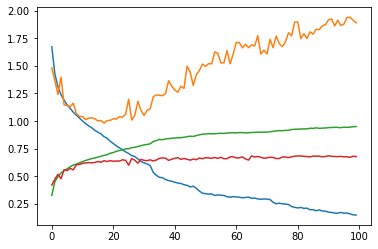

In [53]:
plt.plot(hist), best_acc

In [55]:
pickle.dump(hist, open('squeeze_excit_model/sqeeuze_excit_3blocks_sinstance_hist.hdf5', 'wb'))

In [54]:
## Test
MAX_LOGSTD=10
device = torch.device('cuda')
model = torch.load('squeeze_excit_model/sqeeuze_excit_3blocks_sinstance_model.pt')

test(model, test_loader, device)

- Avg. val_loss: 1.8197 | Avg. val_acc: 0.6946


(1.8196784177341976, 0.6946224575090555)

([<matplotlib.lines.Line2D at 0x7fb9363d7080>,
 0.673725271663416)

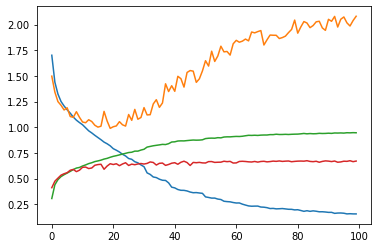

In [44]:
plt.plot(hist), best_acc

In [45]:
## Test
MAX_LOGSTD=10
device = torch.device('cuda')
model = torch.load('squeeze_excit_model/sqeeuze_excit_3blocks_sinstance_model.pt')

test(model, test_loader, device)

- Avg. val_loss: 1.8109 | Avg. val_acc: 0.6902


(1.8108684424862087, 0.690164391195319)

In [48]:
model.att3.lambd.sigmoid()

tensor(0.4523, device='cuda:0', grad_fn=<SigmoidBackward>)

([<matplotlib.lines.Line2D at 0x7fb93670c390>,
 0.6818055168570633)

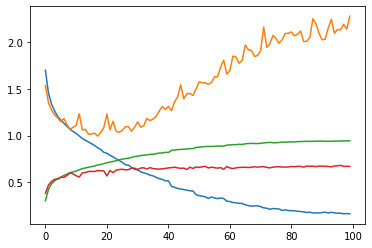

In [38]:
plt.plot(hist), best_acc

In [39]:
## Test
MAX_LOGSTD=10
device = torch.device('cuda')
model = torch.load('squeeze_excit_model/sqeeuze_excit_3blocks_sinstance_model.pt')

test(model, test_loader, device)

- Avg. val_loss: 1.9324 | Avg. val_acc: 0.6924


(1.9324472750352597, 0.6923934243521872)

### 3 Atts

In [56]:
class pretrainedVGG_MultiAtt(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        
        super(pretrainedVGG_MultiAtt, self).__init__()
        pretrained = models.vgg16_bn(pretrained=False)
        
        self.pre_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1)
        self.block1 = pretrained.features[1:7]
        self.block2 = pretrained.features[7:14]
        self.block3 = pretrained.features[14:24]
#         self.block4 = pretrained.features[24:34]
#         self.block5 = pretrained.features[34:]
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Sequential(nn.Linear(in_features=256, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=7, bias=True))
        
        
        self.att1 = SamplingAtt((64, 24, 24), (64, 24, 24))
        self.att2 = SamplingAtt((128, 12, 12), (128, 12, 12))
        self.att3 = SamplingAtt((256, 6, 6), (256, 6, 6))
#         self.att4 = SamplingAtt((512, 4, 4), (512, 4, 4))
        
        
    def forward(self, x):
        x = self.pre_conv(x)
        x = self.block1(x)
        x, kl1 = self.att1(x)
        
        x = self.block2(x)
        x, kl2 = self.att2(x)
        
        x = self.block3(x)
        x, kl3 = self.att3(x)
        
#         x = self.block4(x)
#         x, kl4 = self.att4(x)
        
#         x = self.block5(x)
#         x, kl5 = self.att5(x)
        
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.classifier(x)
        
        return x, torch.tensor([kl1, kl2, kl3]).sum()
        

In [57]:
device = torch.device('cuda')
model = pretrainedVGG_MultiAtt().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [58]:
MAX_LOGSTD=10
model_path = 'squeeze_excit_model/sqeeuze_excit_3blocks_3atts_sinstance_model.pt'

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs)) * kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss = model(inputs)
        
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs))*kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.620263934135437 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.21it/s]

- Avg.loss: 1.6862 | Avg.acc: 0.3146



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4856 | Avg. val_acc: 0.4096
* Update optimal model
Epoch:  2


Loss=1.5014153718948364 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:19<00:00, 23.09it/s]

- Avg.loss: 1.4540 | Avg.acc: 0.4345



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4444 | Avg. val_acc: 0.4411
* Update optimal model
Epoch:  3


Loss=1.1909732818603516 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:19<00:00, 23.16it/s]

- Avg.loss: 1.3403 | Avg.acc: 0.4834



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2469 | Avg. val_acc: 0.5196
* Update optimal model
Epoch:  4


Loss=1.337697148323059 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:19<00:00, 23.23it/s]

- Avg.loss: 1.2667 | Avg.acc: 0.5147



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2267 | Avg. val_acc: 0.5224
* Update optimal model
Epoch:  5


Loss=1.3414912223815918 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:19<00:00, 22.89it/s]

- Avg.loss: 1.2267 | Avg.acc: 0.5347



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2130 | Avg. val_acc: 0.5400
* Update optimal model
Epoch:  6


Loss=0.919951856136322 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 23.09it/s]

- Avg.loss: 1.1738 | Avg.acc: 0.5522



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1414 | Avg. val_acc: 0.5665
* Update optimal model
Epoch:  7


Loss=1.04180109500885 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 22.81it/s]

- Avg.loss: 1.1481 | Avg.acc: 0.5662



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1004 | Avg. val_acc: 0.5779
* Update optimal model
Epoch:  8


Loss=0.922820508480072 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:19<00:00, 22.86it/s]

- Avg.loss: 1.1088 | Avg.acc: 0.5830



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1199 | Avg. val_acc: 0.5695
Epoch:  9


Loss=1.2013894319534302 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:19<00:00, 22.83it/s]

- Avg.loss: 1.0786 | Avg.acc: 0.6003



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1493 | Avg. val_acc: 0.5648
Epoch:  10


Loss=1.0770314931869507 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 23.07it/s]

- Avg.loss: 1.0438 | Avg.acc: 0.6125



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0630 | Avg. val_acc: 0.5957
* Update optimal model
Epoch:  11


Loss=0.8727660179138184 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.07it/s]

- Avg.loss: 1.0243 | Avg.acc: 0.6212



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0810 | Avg. val_acc: 0.6007
* Update optimal model
Epoch:  12


Loss=0.8158835172653198 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 22.92it/s]

- Avg.loss: 0.9884 | Avg.acc: 0.6373



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0531 | Avg. val_acc: 0.6152
* Update optimal model
Epoch:  13


Loss=0.7734507322311401 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.09it/s]

- Avg.loss: 0.9726 | Avg.acc: 0.6460



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0389 | Avg. val_acc: 0.6127
Epoch:  14


Loss=0.9018564820289612 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 22.95it/s]

- Avg.loss: 0.9423 | Avg.acc: 0.6559



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0460 | Avg. val_acc: 0.6124
Epoch:  15


Loss=0.9007710814476013 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.94it/s]

- Avg.loss: 0.9237 | Avg.acc: 0.6623



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0210 | Avg. val_acc: 0.6219
* Update optimal model
Epoch:  16


Loss=0.6714054346084595 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.92it/s]

- Avg.loss: 0.9027 | Avg.acc: 0.6734



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0455 | Avg. val_acc: 0.6183
Epoch:  17


Loss=0.8409867882728577 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.62it/s]

- Avg.loss: 0.8842 | Avg.acc: 0.6770



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1174 | Avg. val_acc: 0.6013
Epoch:  18


Loss=0.9604801535606384 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.10it/s]

- Avg.loss: 0.8619 | Avg.acc: 0.6881



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0180 | Avg. val_acc: 0.6347
* Update optimal model
Epoch:  19


Loss=0.8544553518295288 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 23.07it/s]

- Avg.loss: 0.8390 | Avg.acc: 0.6959



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0238 | Avg. val_acc: 0.6336
Epoch:  20


Loss=1.0243022441864014 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:19<00:00, 22.82it/s]

- Avg.loss: 0.8224 | Avg.acc: 0.7049



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0796 | Avg. val_acc: 0.6208
Epoch:  21


Loss=1.0152561664581299 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 22.81it/s]

- Avg.loss: 0.8053 | Avg.acc: 0.7135



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0125 | Avg. val_acc: 0.6389
* Update optimal model
Epoch:  22


Loss=0.7195882797241211 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]

- Avg.loss: 0.7750 | Avg.acc: 0.7225



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0876 | Avg. val_acc: 0.6358
Epoch:  23


Loss=0.7162335515022278 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.96it/s]

- Avg.loss: 0.7687 | Avg.acc: 0.7263



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0243 | Avg. val_acc: 0.6422
* Update optimal model
Epoch:  24


Loss=0.8253329396247864 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.79it/s]

- Avg.loss: 0.7459 | Avg.acc: 0.7364



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1751 | Avg. val_acc: 0.6077
Epoch:  25


Loss=0.9330878257751465 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.04it/s]

- Avg.loss: 0.7305 | Avg.acc: 0.7431



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0615 | Avg. val_acc: 0.6347
Epoch:  26


Loss=0.5371859669685364 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.88it/s]

- Avg.loss: 0.7133 | Avg.acc: 0.7487



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0550 | Avg. val_acc: 0.6559
* Update optimal model
Epoch:  27


Loss=0.8678117990493774 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 22.52it/s]

- Avg.loss: 0.6960 | Avg.acc: 0.7533



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1871 | Avg. val_acc: 0.6202
Epoch:  28


Loss=0.6977754831314087 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.07it/s]

- Avg.loss: 0.6768 | Avg.acc: 0.7622



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1341 | Avg. val_acc: 0.6461
Epoch:  29


Loss=0.5848684310913086 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]

- Avg.loss: 0.6617 | Avg.acc: 0.7684



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2947 | Avg. val_acc: 0.6303
Epoch:  30


Loss=0.649243175983429 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 22.96it/s]

- Avg.loss: 0.6410 | Avg.acc: 0.7765



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1843 | Avg. val_acc: 0.6542
Epoch:  31


Loss=0.6268209218978882 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 22.96it/s]

- Avg.loss: 0.6346 | Avg.acc: 0.7763



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1766 | Avg. val_acc: 0.6383
Epoch:  32


Loss=0.7361488342285156 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.12it/s]

- Avg.loss: 0.6191 | Avg.acc: 0.7835



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2275 | Avg. val_acc: 0.6506
Epoch    32: reducing learning rate of group 0 to 7.5000e-04.
Epoch:  33


Loss=0.5651558637619019 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 22.82it/s]

- Avg.loss: 0.5632 | Avg.acc: 0.8045



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3239 | Avg. val_acc: 0.6386
Epoch:  34


Loss=0.622641921043396 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 22.70it/s]

- Avg.loss: 0.5491 | Avg.acc: 0.8087



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3495 | Avg. val_acc: 0.6562
* Update optimal model
Epoch:  35


Loss=0.36353135108947754 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]

- Avg.loss: 0.5245 | Avg.acc: 0.8179



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3448 | Avg. val_acc: 0.6392
Epoch:  36


Loss=0.736380934715271 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 22.76it/s]

- Avg.loss: 0.5153 | Avg.acc: 0.8220



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4056 | Avg. val_acc: 0.6445
Epoch:  37


Loss=0.7013993859291077 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 22.73it/s]

- Avg.loss: 0.5099 | Avg.acc: 0.8227



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2975 | Avg. val_acc: 0.6590
* Update optimal model
Epoch:  38


Loss=0.5337628126144409 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 22.66it/s]

- Avg.loss: 0.5003 | Avg.acc: 0.8276



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3915 | Avg. val_acc: 0.6534
Epoch:  39


Loss=0.44009929895401 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 22.92it/s]

- Avg.loss: 0.4907 | Avg.acc: 0.8301



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3385 | Avg. val_acc: 0.6500
Epoch:  40


Loss=0.7722383141517639 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 22.71it/s]

- Avg.loss: 0.4806 | Avg.acc: 0.8304



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4662 | Avg. val_acc: 0.6537
Epoch:  41


Loss=0.39465534687042236 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.51it/s]

- Avg.loss: 0.4696 | Avg.acc: 0.8361



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4505 | Avg. val_acc: 0.6539
Epoch:  42


Loss=0.5435311198234558 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]

- Avg.loss: 0.4740 | Avg.acc: 0.8357



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4058 | Avg. val_acc: 0.6484
Epoch:  43


Loss=0.8332118391990662 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.97it/s]

- Avg.loss: 0.4677 | Avg.acc: 0.8357



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4381 | Avg. val_acc: 0.6369
Epoch    43: reducing learning rate of group 0 to 5.6250e-04.
Epoch:  44


Loss=0.3368864953517914 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.65it/s]

- Avg.loss: 0.4304 | Avg.acc: 0.8513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4486 | Avg. val_acc: 0.6609
* Update optimal model
Epoch:  45


Loss=0.7618404030799866 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 22.86it/s]

- Avg.loss: 0.4087 | Avg.acc: 0.8595



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4992 | Avg. val_acc: 0.6478
Epoch:  46


Loss=0.3497002422809601 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 0.4126 | Avg.acc: 0.8584



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4408 | Avg. val_acc: 0.6523
Epoch:  47


Loss=0.3447367548942566 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 22.85it/s]

- Avg.loss: 0.4040 | Avg.acc: 0.8599



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5258 | Avg. val_acc: 0.6598
Epoch:  48


Loss=0.4813130795955658 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.15it/s]

- Avg.loss: 0.3897 | Avg.acc: 0.8617



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7032 | Avg. val_acc: 0.6525
Epoch:  49


Loss=0.3468042314052582 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.58it/s]

- Avg.loss: 0.3905 | Avg.acc: 0.8642



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6280 | Avg. val_acc: 0.6523
Epoch:  50


Loss=0.5959988236427307 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.23it/s]

- Avg.loss: 0.3857 | Avg.acc: 0.8663



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5186 | Avg. val_acc: 0.6682
* Update optimal model
Epoch:  51


Loss=0.5485671162605286 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.77it/s]

- Avg.loss: 0.3808 | Avg.acc: 0.8697



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5285 | Avg. val_acc: 0.6548
Epoch:  52


Loss=0.4204620122909546 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.53it/s]

- Avg.loss: 0.3794 | Avg.acc: 0.8692



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5993 | Avg. val_acc: 0.6498
Epoch:  53


Loss=0.46455028653144836 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:20<00:00, 22.40it/s]

- Avg.loss: 0.3731 | Avg.acc: 0.8693



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5610 | Avg. val_acc: 0.6601
Epoch:  54


Loss=0.37257707118988037 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.15it/s]

- Avg.loss: 0.3738 | Avg.acc: 0.8723



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5693 | Avg. val_acc: 0.6615
Epoch:  55


Loss=0.6036737561225891 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 22.60it/s]

- Avg.loss: 0.3701 | Avg.acc: 0.8714



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7848 | Avg. val_acc: 0.6531
Epoch:  56


Loss=0.13020408153533936 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.77it/s]

- Avg.loss: 0.3620 | Avg.acc: 0.8750



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6503 | Avg. val_acc: 0.6601
Epoch    56: reducing learning rate of group 0 to 4.2188e-04.
Epoch:  57


Loss=0.7005138993263245 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.77it/s]

- Avg.loss: 0.3361 | Avg.acc: 0.8833



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7094 | Avg. val_acc: 0.6668
Epoch:  58


Loss=0.22942662239074707 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.66it/s]

- Avg.loss: 0.3227 | Avg.acc: 0.8893



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8445 | Avg. val_acc: 0.6595
Epoch:  59


Loss=0.578831136226654 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]

- Avg.loss: 0.3199 | Avg.acc: 0.8881



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8110 | Avg. val_acc: 0.6525
Epoch:  60


Loss=0.4254611134529114 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.78it/s]

- Avg.loss: 0.3253 | Avg.acc: 0.8863



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8000 | Avg. val_acc: 0.6709
* Update optimal model
Epoch:  61


Loss=0.36604151129722595 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.97it/s]

- Avg.loss: 0.3205 | Avg.acc: 0.8895



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7093 | Avg. val_acc: 0.6665
Epoch:  62


Loss=0.45096921920776367 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 22.79it/s]

- Avg.loss: 0.3119 | Avg.acc: 0.8911



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8499 | Avg. val_acc: 0.6598
Epoch:  63


Loss=0.22664931416511536 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.58it/s]

- Avg.loss: 0.3231 | Avg.acc: 0.8904



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7216 | Avg. val_acc: 0.6654
Epoch:  64


Loss=0.24118635058403015 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:20<00:00, 22.43it/s]

- Avg.loss: 0.3187 | Avg.acc: 0.8917



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7241 | Avg. val_acc: 0.6748
* Update optimal model
Epoch:  65


Loss=0.2950771152973175 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.93it/s]

- Avg.loss: 0.3117 | Avg.acc: 0.8930



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7206 | Avg. val_acc: 0.6668
Epoch:  66


Loss=0.5892249345779419 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.94it/s]

- Avg.loss: 0.3113 | Avg.acc: 0.8938



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6579 | Avg. val_acc: 0.6665
Epoch:  67


Loss=0.08142206072807312 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.62it/s]     

- Avg.loss: 0.3082 | Avg.acc: 0.8932



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7324 | Avg. val_acc: 0.6679
Epoch:  68


Loss=0.34084370732307434 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.64it/s]

- Avg.loss: 0.2996 | Avg.acc: 0.8981



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7316 | Avg. val_acc: 0.6640
Epoch:  69


Loss=0.49176302552223206 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.05it/s]

- Avg.loss: 0.3021 | Avg.acc: 0.8974



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6800 | Avg. val_acc: 0.6654
Epoch:  70


Loss=0.4892268776893616 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 22.93it/s]

- Avg.loss: 0.2983 | Avg.acc: 0.8971



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6904 | Avg. val_acc: 0.6723
Epoch    70: reducing learning rate of group 0 to 3.1641e-04.
Epoch:  71


Loss=0.11158621311187744 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.78it/s]     

- Avg.loss: 0.2823 | Avg.acc: 0.9046



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8442 | Avg. val_acc: 0.6598
Epoch:  72


Loss=0.17273740470409393 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.65it/s]

- Avg.loss: 0.2708 | Avg.acc: 0.9077



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7568 | Avg. val_acc: 0.6643
Epoch:  73


Loss=0.15672066807746887 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.89it/s]

- Avg.loss: 0.2710 | Avg.acc: 0.9060



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8459 | Avg. val_acc: 0.6651
Epoch:  74


Loss=0.11309989541769028 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.19it/s]

- Avg.loss: 0.2679 | Avg.acc: 0.9079



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8478 | Avg. val_acc: 0.6665
Epoch:  75


Loss=0.5195136070251465 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.96it/s]

- Avg.loss: 0.2616 | Avg.acc: 0.9084



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9729 | Avg. val_acc: 0.6709
Epoch:  76


Loss=0.2102380245923996 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.97it/s]

- Avg.loss: 0.2594 | Avg.acc: 0.9105



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8352 | Avg. val_acc: 0.6695
Epoch    76: reducing learning rate of group 0 to 2.3730e-04.
Epoch:  77


Loss=0.27662235498428345 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.93it/s]

- Avg.loss: 0.2401 | Avg.acc: 0.9174



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8605 | Avg. val_acc: 0.6743
Epoch:  78


Loss=0.2910866439342499 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.80it/s]

- Avg.loss: 0.2389 | Avg.acc: 0.9176



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9422 | Avg. val_acc: 0.6712
Epoch:  79


Loss=0.3651406168937683 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.73it/s]

- Avg.loss: 0.2384 | Avg.acc: 0.9173



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8965 | Avg. val_acc: 0.6771
* Update optimal model
Epoch:  80


Loss=0.09529481083154678 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]

- Avg.loss: 0.2309 | Avg.acc: 0.9192



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8592 | Avg. val_acc: 0.6824
* Update optimal model
Epoch:  81


Loss=0.36545848846435547 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:20<00:00, 22.11it/s]

- Avg.loss: 0.2323 | Avg.acc: 0.9193



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9041 | Avg. val_acc: 0.6712
Epoch:  82


Loss=0.13275094330310822 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.75it/s]

- Avg.loss: 0.2313 | Avg.acc: 0.9205



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9276 | Avg. val_acc: 0.6776
Epoch:  83


Loss=0.1844988316297531 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.74it/s]

- Avg.loss: 0.2310 | Avg.acc: 0.9208



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7853 | Avg. val_acc: 0.6810
Epoch:  84


Loss=0.18009522557258606 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.73it/s]

- Avg.loss: 0.2220 | Avg.acc: 0.9248



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8303 | Avg. val_acc: 0.6779
Epoch:  85


Loss=0.07962647825479507 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.88it/s]

- Avg.loss: 0.2197 | Avg.acc: 0.9239



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8931 | Avg. val_acc: 0.6804
Epoch:  86


Loss=0.09884607046842575 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 22.15it/s]     

- Avg.loss: 0.2182 | Avg.acc: 0.9260



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8601 | Avg. val_acc: 0.6804
Epoch    86: reducing learning rate of group 0 to 1.7798e-04.
Epoch:  87


Loss=0.18552418053150177 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.63it/s]

- Avg.loss: 0.2122 | Avg.acc: 0.9280



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9038 | Avg. val_acc: 0.6815
Epoch:  88


Loss=0.05124831199645996 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.86it/s]      

- Avg.loss: 0.2032 | Avg.acc: 0.9305



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9222 | Avg. val_acc: 0.6832
* Update optimal model
Epoch:  89


Loss=0.36729079484939575 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.86it/s]

- Avg.loss: 0.1978 | Avg.acc: 0.9328



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0579 | Avg. val_acc: 0.6851
* Update optimal model
Epoch:  90


Loss=0.4013819694519043 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.71it/s]

- Avg.loss: 0.2057 | Avg.acc: 0.9284



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0141 | Avg. val_acc: 0.6785
Epoch:  91


Loss=0.10064207762479782 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:20<00:00, 22.00it/s]

- Avg.loss: 0.1991 | Avg.acc: 0.9327



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9787 | Avg. val_acc: 0.6732
Epoch:  92


Loss=0.08995380997657776 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:20<00:00, 22.21it/s]

- Avg.loss: 0.2019 | Avg.acc: 0.9316



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9568 | Avg. val_acc: 0.6807
Epoch:  93


Loss=0.16023068130016327 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.61it/s]

- Avg.loss: 0.1991 | Avg.acc: 0.9302



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9574 | Avg. val_acc: 0.6810
Epoch:  94


Loss=0.1286119967699051 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.90it/s]

- Avg.loss: 0.1967 | Avg.acc: 0.9324



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0735 | Avg. val_acc: 0.6743
Epoch:  95


Loss=0.056583650410175323 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.64it/s]

- Avg.loss: 0.1924 | Avg.acc: 0.9334



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9551 | Avg. val_acc: 0.6695
Epoch    95: reducing learning rate of group 0 to 1.3348e-04.
Epoch:  96


Loss=0.18016782402992249 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.85it/s]

- Avg.loss: 0.1884 | Avg.acc: 0.9353



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9981 | Avg. val_acc: 0.6790
Epoch:  97


Loss=0.09501555562019348 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.87it/s]

- Avg.loss: 0.1770 | Avg.acc: 0.9387



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0717 | Avg. val_acc: 0.6818
Epoch:  98


Loss=0.22416478395462036 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.83it/s]

- Avg.loss: 0.1803 | Avg.acc: 0.9381



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0234 | Avg. val_acc: 0.6849
Epoch:  99


Loss=0.2965746521949768 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:20<00:00, 22.13it/s]

- Avg.loss: 0.1792 | Avg.acc: 0.9379



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9665 | Avg. val_acc: 0.6757
Epoch:  100


Loss=0.10472804307937622 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 22.18it/s]     

- Avg.loss: 0.1769 | Avg.acc: 0.9377


- Avg. val_loss: 2.0116 | Avg. val_acc: 0.6804
Finished Training


In [59]:
best_acc

0.6851490665923655

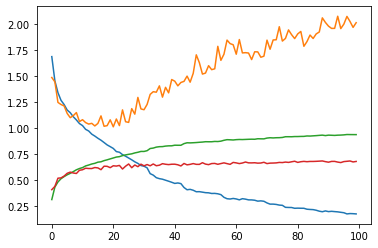

In [62]:
plt.plot(hist)
pickle.dump(hist, open('squeeze_excit_model/sqeeuze_excit_3blocks_3atts_sinstance_hist.hdf5', 'wb'))


In [60]:
## Test
MAX_LOGSTD=10
device = torch.device('cuda')
model = torch.load('squeeze_excit_model/sqeeuze_excit_3blocks_3atts_sinstance_model.pt')

test(model, test_loader, device)

- Avg. val_loss: 1.9144 | Avg. val_acc: 0.6918


(1.9143673290811762, 0.6918361660629702)

In [46]:
class SamplingLatentSpace(nn.Module):
    def __init__(self, in_size, out_size):
        super(SamplingLatentSpace, self).__init__()
        self.out_size = out_size
        self.fc = nn.Linear(in_size[1]*in_size[2], 2*out_size[1]*out_size[2])
    
    def reparameterize(self, mu, logvar):
        
        if self.training:
            return mu + torch.randn_like(logvar)*torch.exp(logvar / 2)
        else:
            return mu
    def kl_loss(self, mu, logvar):
        logvar = logvar.clamp(max=MAX_LOGSTD)
        return 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1. - logvar)
        
    def forward(self, x):
        x = x.reshape(x.size(0), x.size(1), x.size(2)*x.size(3))
        x = self.fc(x)

        x = x.reshape(x.size(0), x.size(1), 2, -1)
        
        x_mu = x[:,:,0,:]
        x_logvar = x[:,:,1,:]
        
        z = self.reparameterize(x_mu, x_logvar)
        z = z.reshape(z.size(0), z.size(1), self.out_size[1], self.out_size[2])
        
        return z, self.kl_loss(x_mu, x_logvar)
        

In [138]:
c = SamplingLatentSpace((128, 12, 12), (128, 12, 12))(torch.rand(12, 128, 12, 12))
c[1]

tensor(18436.4395, grad_fn=<MulBackward0>)

In [47]:
class SamplingAtt(nn.Module):
    def __init__(self, in_size, out_size):
        super(SamplingAtt, self).__init__()

        self.f_depth = SamplingDepth(in_size[0], out_size[0])
#         self.f_spatial = SamplingSize((in_size[1], out_size[1]), out_size[0])
        self.f_instance = SamplingInstance(in_size, out_size)
        self.f_sampling = SamplingLatentSpace(in_size, out_size)

#         self.lambd = nn.Parameter(torch.tensor(0.), requires_grad=True)
#         self.lambd_spatial = nn.Parameter(torch.tensor(0.), requires_grad=True)
#         self.lambd_instance = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        x_depth = self.f_depth(x)
        x_instance = self.f_instance(x)

        z, kl_loss = self.f_sampling(x)
#         z = x
#         out = (self.lambd.sigmoid()*(z*x_depth[:,:,None,None])) + ((1-self.lambd.sigmoid())*(z*x_instance))
        out = (z*x_depth[:,:,None,None]) + (z*x_instance)

        return out, kl_loss
#         return out, 0.0

In [48]:
class pretrainedVGG_MultiAtt(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        
        super(pretrainedVGG_MultiAtt, self).__init__()
        pretrained = models.vgg16_bn(pretrained=False)
        
        self.pre_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1)
        self.block1 = pretrained.features[1:7]
        self.block2 = pretrained.features[7:14]
        self.block3 = pretrained.features[14:24]
#         self.block4 = pretrained.features[24:34]
#         self.block5 = pretrained.features[34:]
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Sequential(nn.Linear(in_features=256, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=7, bias=True))
        
        
        self.att2 = SamplingAtt((128, 12, 12), (128, 12, 12))
        self.att3 = SamplingAtt((256, 6, 6), (256, 6, 6))
#         self.att4 = SamplingAtt((512, 4, 4), (512, 4, 4))
        
        
    def forward(self, x):
        x = self.pre_conv(x)
        x = self.block1(x)
        
        x = self.block2(x)
        x, kl2 = self.att2(x)
        
        x = self.block3(x)
        x, kl3 = self.att3(x)
        
#         x = self.block4(x)
#         x, kl4 = self.att4(x)
        
#         x = self.block5(x)
#         x, kl5 = self.att5(x)
        
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.classifier(x)
        
        return x, torch.tensor([kl2, kl3]).sum()
        

In [49]:
device = torch.device('cuda')
model = pretrainedVGG_MultiAtt().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [ ]:
MAX_LOGSTD=10
model_path = 'squeeze_excit_model/sqeeuze_excit_3blocks_var_sinstance_model.pt'

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs)) * kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss = model(inputs)
        
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs))*kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=22705.775390625 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [00:19<00:00, 22.73it/s]

- Avg.loss: 17828.2069 | Avg.acc: 0.2586



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 23847.7934 | Avg. val_acc: 0.3104
* Update optimal model
Epoch:  2


Loss=25788.84765625 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.77it/s]

- Avg.loss: 26273.4193 | Avg.acc: 0.3429



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 26233.7709 | Avg. val_acc: 0.4447
* Update optimal model
Epoch:  3


Loss=30115.201171875 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:19<00:00, 22.56it/s]

- Avg.loss: 28717.4473 | Avg.acc: 0.4377



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 29150.9422 | Avg. val_acc: 0.5043
* Update optimal model
Epoch:  4


Loss=28636.494140625 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:19<00:00, 22.59it/s]

- Avg.loss: 29345.5477 | Avg.acc: 0.4859



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 27854.7401 | Avg. val_acc: 0.5185
* Update optimal model
Epoch:  5


Loss=28300.568359375 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 22.48it/s]

- Avg.loss: 28658.9425 | Avg.acc: 0.5119



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 27804.8960 | Avg. val_acc: 0.5383
* Update optimal model
Epoch:  6


Loss=29918.046875 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 22.52it/s]

- Avg.loss: 28755.9361 | Avg.acc: 0.5367



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 29978.7424 | Avg. val_acc: 0.5548
* Update optimal model
Epoch:  7


Loss=30417.87109375 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:20<00:00, 22.21it/s]

- Avg.loss: 29841.5749 | Avg.acc: 0.5507



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 33415.2652 | Avg. val_acc: 0.5026
Epoch:  8


Loss=31255.91796875 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 22.62it/s]

- Avg.loss: 30260.2784 | Avg.acc: 0.5659



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 30205.1495 | Avg. val_acc: 0.5734
* Update optimal model
Epoch:  9


Loss=31949.458984375 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:20<00:00, 22.28it/s]

- Avg.loss: 31182.4592 | Avg.acc: 0.5810



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 32794.4899 | Avg. val_acc: 0.5874
* Update optimal model
Epoch:  10


Loss=32308.912109375 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:19<00:00, 22.73it/s]

- Avg.loss: 31630.6865 | Avg.acc: 0.5903



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 34200.4408 | Avg. val_acc: 0.5952
* Update optimal model
Epoch:  11


Loss=33235.27734375 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 22.80it/s]

- Avg.loss: 32578.5210 | Avg.acc: 0.6009



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 33969.5791 | Avg. val_acc: 0.6032
* Update optimal model
Epoch:  12


Loss=32468.521484375 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 22.87it/s]

- Avg.loss: 32739.6777 | Avg.acc: 0.6151



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 36126.5931 | Avg. val_acc: 0.6055
* Update optimal model
Epoch:  13


Loss=32494.96484375 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 22.86it/s]

- Avg.loss: 33028.5223 | Avg.acc: 0.6220



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35671.8005 | Avg. val_acc: 0.6127
* Update optimal model
Epoch:  14


Loss=32684.482421875 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:20<00:00, 22.08it/s]

- Avg.loss: 32677.6920 | Avg.acc: 0.6265



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35913.3231 | Avg. val_acc: 0.6096
Epoch:  15


Loss=32457.611328125 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:21<00:00, 21.17it/s]

- Avg.loss: 33130.4043 | Avg.acc: 0.6416



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 36677.0783 | Avg. val_acc: 0.6041
Epoch:  16


Loss=33845.578125 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:20<00:00, 22.28it/s]

- Avg.loss: 33275.3203 | Avg.acc: 0.6412



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35574.4236 | Avg. val_acc: 0.5901
Epoch:  17


Loss=33419.24609375 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 22.83it/s]

- Avg.loss: 33984.0575 | Avg.acc: 0.6511



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 37086.7738 | Avg. val_acc: 0.6138
* Update optimal model
Epoch:  18


Loss=34302.76171875 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:19<00:00, 22.63it/s]

- Avg.loss: 34067.0177 | Avg.acc: 0.6595



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 36549.5364 | Avg. val_acc: 0.6325
* Update optimal model
Epoch:  19


Loss=35550.92578125 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.56it/s]

- Avg.loss: 34875.6161 | Avg.acc: 0.6704



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 36569.9047 | Avg. val_acc: 0.6294
Epoch:  20


Loss=35246.26953125 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 22.55it/s]

- Avg.loss: 35246.3825 | Avg.acc: 0.6755



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 38313.6607 | Avg. val_acc: 0.6147
Epoch:  21


Loss=36007.86328125 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.86it/s]

- Avg.loss: 35637.3747 | Avg.acc: 0.6878



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 36945.2837 | Avg. val_acc: 0.6339
* Update optimal model
Epoch:  22


Loss=37193.55078125 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:19<00:00, 22.47it/s]

- Avg.loss: 36273.1230 | Avg.acc: 0.6906



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 37945.1846 | Avg. val_acc: 0.6241
Epoch:  23


Loss=36254.9921875 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 22.66it/s]

- Avg.loss: 36459.3646 | Avg.acc: 0.6956



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 39265.2508 | Avg. val_acc: 0.6264
Epoch:  24


Loss=35998.3828125 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 22.55it/s]

- Avg.loss: 36350.6522 | Avg.acc: 0.7035



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 37690.4915 | Avg. val_acc: 0.6094
Epoch:  25


Loss=36878.49609375 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 22.55it/s]

- Avg.loss: 36564.6647 | Avg.acc: 0.7156



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 39564.2974 | Avg. val_acc: 0.6456
* Update optimal model
Epoch:  26


Loss=37077.6484375 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.58it/s]

- Avg.loss: 37092.4734 | Avg.acc: 0.7202



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 37288.0405 | Avg. val_acc: 0.6219
Epoch:  27


Loss=37009.6796875 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 22.81it/s]

- Avg.loss: 37384.9998 | Avg.acc: 0.7251



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 38045.9135 | Avg. val_acc: 0.6436
Epoch:  28


Loss=36785.6640625 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.75it/s]

- Avg.loss: 37623.9273 | Avg.acc: 0.7340



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 39416.7180 | Avg. val_acc: 0.6414
Epoch:  29


Loss=37056.28125 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.89it/s]

- Avg.loss: 37785.1176 | Avg.acc: 0.7366



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 40878.0890 | Avg. val_acc: 0.6250
Epoch:  30


Loss=37799.1953125 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 22.66it/s]

- Avg.loss: 37300.5157 | Avg.acc: 0.7426



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 38344.4201 | Avg. val_acc: 0.6317
Epoch:  31


Loss=37890.9453125 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.71it/s]

- Avg.loss: 37800.1539 | Avg.acc: 0.7479



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 38350.8837 | Avg. val_acc: 0.6305
Epoch    31: reducing learning rate of group 0 to 7.5000e-04.
Epoch:  32


Loss=38336.58203125 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:20<00:00, 22.31it/s]

- Avg.loss: 38640.6729 | Avg.acc: 0.7708



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 41740.0181 | Avg. val_acc: 0.6509
* Update optimal model
Epoch:  33


Loss=39495.78515625 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 22.61it/s]

- Avg.loss: 38879.2265 | Avg.acc: 0.7809



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 42399.5806 | Avg. val_acc: 0.6339
Epoch:  34


Loss=39347.62109375 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.45it/s]

- Avg.loss: 39061.5694 | Avg.acc: 0.7854



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 41437.4861 | Avg. val_acc: 0.6500
Epoch:  35


Loss=38969.40234375 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.62it/s]

- Avg.loss: 39406.5356 | Avg.acc: 0.7949



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 41178.4771 | Avg. val_acc: 0.6375
Epoch:  36


Loss=39996.8359375 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.82it/s]

- Avg.loss: 39729.5991 | Avg.acc: 0.7951



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 42298.2204 | Avg. val_acc: 0.6383
Epoch:  37


Loss=39234.63671875 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 22.74it/s]

- Avg.loss: 39851.9787 | Avg.acc: 0.8016



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 42228.1757 | Avg. val_acc: 0.6464
Epoch:  38


Loss=39769.98046875 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 22.58it/s]

- Avg.loss: 39885.3566 | Avg.acc: 0.8036



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 42890.5557 | Avg. val_acc: 0.6378
Epoch    38: reducing learning rate of group 0 to 5.6250e-04.
Epoch:  39


Loss=40851.73828125 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.63it/s]

- Avg.loss: 40091.2214 | Avg.acc: 0.8218



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 42794.1933 | Avg. val_acc: 0.6364
Epoch:  40


Loss=40706.96875 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.58it/s]

- Avg.loss: 40396.8762 | Avg.acc: 0.8291



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 41977.7779 | Avg. val_acc: 0.6534
* Update optimal model
Epoch:  41


Loss=41744.84375 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.86it/s]

- Avg.loss: 40894.9031 | Avg.acc: 0.8320



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 42615.0137 | Avg. val_acc: 0.6528
Epoch:  42


Loss=41214.3515625 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 22.71it/s]

- Avg.loss: 40945.8976 | Avg.acc: 0.8342



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 41893.6718 | Avg. val_acc: 0.6467
Epoch:  43


Loss=39706.2421875 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.52it/s]

- Avg.loss: 40757.0986 | Avg.acc: 0.8349



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 41831.1836 | Avg. val_acc: 0.6559
* Update optimal model
Epoch:  44


Loss=41678.890625 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.94it/s]

- Avg.loss: 41333.5218 | Avg.acc: 0.8348



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 42751.8200 | Avg. val_acc: 0.6447
Epoch:  45


Loss=42120.01953125 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.47it/s]

- Avg.loss: 41341.4987 | Avg.acc: 0.8417



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 43840.6239 | Avg. val_acc: 0.6537
Epoch:  46


Loss=41960.34375 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.73it/s]

- Avg.loss: 41855.9940 | Avg.acc: 0.8414



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 42866.4105 | Avg. val_acc: 0.6459
Epoch:  47


Loss=41587.2109375 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.82it/s]

- Avg.loss: 41533.1425 | Avg.acc: 0.8441



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 43495.9279 | Avg. val_acc: 0.6347
Epoch:  48


Loss=41609.6953125 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 22.59it/s]

- Avg.loss: 41267.1287 | Avg.acc: 0.8653



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 41573.1223 | Avg. val_acc: 0.6492
Epoch:  53


Loss=41226.26953125 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:20<00:00, 22.43it/s]

- Avg.loss: 41248.4118 | Avg.acc: 0.8671



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 42400.7881 | Avg. val_acc: 0.6542
Epoch:  54


Loss=41185.99609375 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.55it/s]

- Avg.loss: 40951.5313 | Avg.acc: 0.8696



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 41849.4030 | Avg. val_acc: 0.6545
Epoch:  55


Loss=41010.140625 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.75it/s]

- Avg.loss: 40833.3042 | Avg.acc: 0.8709



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 42312.7388 | Avg. val_acc: 0.6475
Epoch    55: reducing learning rate of group 0 to 3.1641e-04.
Epoch:  56


Loss=40810.9140625 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.86it/s]

- Avg.loss: 40929.5108 | Avg.acc: 0.8770



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 42304.7028 | Avg. val_acc: 0.6556
Epoch:  57


Loss=40678.671875 Batch_id=177 Accuracy=0.890625:  40%|███▉      | 178/449 [00:08<00:11, 23.44it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=40977.71484375 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.73it/s]

- Avg.loss: 40869.6344 | Avg.acc: 0.8953



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 41180.7701 | Avg. val_acc: 0.6601
Epoch:  69


Loss=40981.65625 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 22.73it/s]

- Avg.loss: 40491.6915 | Avg.acc: 0.8948



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 41323.2192 | Avg. val_acc: 0.6562
Epoch:  70


Loss=40440.37890625 Batch_id=96 Accuracy=0.9375:  22%|██▏       | 97/449 [00:04<00:14, 23.48it/s]  

In [52]:
model = torch.load('squeeze_excit_model/sqeeuze_excit_3blocks_var_sinstance_model.pt')
## Test
MAX_LOGSTD=10
device = torch.device('cuda')

test(model, test_loader, device)

- Avg. val_loss: 41009.0061 | Avg. val_acc: 0.6785


(41009.006120045626, 0.678461967121761)